## Basic Sales Analytics

This notebook performs basic analysis of the sales.

In [1]:
# Required Libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.stats import zscore
import scipy.stats as stats

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
plt.style.use('ggplot') 
pd.options.display.float_format = '{:.2f}'.format 
pd.options.display.max_columns=None
pd.options.display.max_rows=None
pd.set_option('display.max_colwidth', None)

In [2]:
# Read the dataset

df = pd.read_csv('../customer_shopping_data.csv')
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


In [3]:
print("The data has {0} rows and {1} features.".format(df.shape[0],df.shape[1]))

The data has 99457 rows and 10 features.


## Data Overview

Brief overview and exploration of the data.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB


In [5]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'])
df['invoice_year'] = df['invoice_date'].dt.year
df['invoice_month'] = df['invoice_date'].dt.strftime('%B')
df['total_revenue'] = df['quantity'] * df['price']
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,invoice_year,invoice_month,total_revenue
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,2022-05-08,Kanyon,2022,May,7502.00
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,2021,December,5401.53
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,2021-09-11,Metrocity,2021,September,300.08
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM,2021,May,15004.25
4,I337046,C189076,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon,2021,October,242.40


<!-- What was the total sales revenue for the last quarter?
How does the sales revenue of this year compare to the same period last year?
What is the average transaction value for online purchases versus in-store purchases?
Which month had the highest sales revenue in the last year?
How has the sales revenue changed over the past six months?
Is there a specific day of the week that consistently generates the highest sales?
What is the total revenue generated by each payment method?
What is the correlation between invoice quantity and total sales revenue?
How does sales revenue vary among different shopping malls?
Can you identify any trends or patterns in the distribution of sales revenue? -->

In [10]:
# HELPER FUNCTIONS

def format_revenue_with_thousand_separator(x):
    """
        function to format the revenue values with thousand separators
    """
    return "${:,.2f}".format(x)

class ExploreData():
    
    def __init__(self,data):
        
        self.data = data
    
    def percentage_missing(self):
        
        """Get summary of missing values in the data
        """
        missing = pd.DataFrame(self.data.isnull().sum().reset_index().values, columns=['variable','missing'])
        missing['%_missing'] = missing['missing']/len(self.data) * 100
        d_types = pd.DataFrame(self.data.dtypes).reset_index()
        d_types.columns = ['variable', 'dtype']
        missing = missing.merge(d_types, on='variable')

        return missing


    def check_skewness(self, variable):
        
        """Check skewness of a variables
        """

        # calculate skewness
        print("Skewness coefficient: ", self.data[variable].skew())

        # Plot histogram
        plt.figure(figsize=(12,5))
        plt.hist(self.data[variable], bins='auto', alpha=0.7, rwidth=0.85)
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Value',color='blue',fontsize=11)
        plt.ylabel('Frequency',color='blue',fontsize=11)
        plt.title(f'Distribution of {variable}', fontdict={"size":12, "color":"blue"})
        
        # add thousand separator to y-axis labels
        plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
        plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

        plt.xticks(rotation=0)
        plt.grid(True)
        plt.tick_params(axis='x', which='both', labelsize=9, labelcolor='blue')
        plt.tick_params(axis='y', which='both', labelsize=9, labelcolor='blue')
        plt.show()


    def get_statistical_summary(self, variableType=None):
        
        """
        Get statistical summary of numerical varaibles the dataframe"""
                   
        # missing values and data types
        d_types = pd.DataFrame(self.data.dtypes).reset_index()
        d_types.columns = ['variable', 'dtype']
        
        missing = pd.DataFrame(self.data.isnull().sum().reset_index().values, columns=['variable','missing'])
        missing['%_missing'] = missing['missing']/len(self.data) * 100
        d_types_df = pd.DataFrame(self.data.dtypes).reset_index()
        d_types_df.columns = ['variable', 'dtype']
        
        # mapping of data types to human-readable text
        data_type_mapping = {
                                np.dtype('O'): 'Text',
                                np.dtype('int64'): 'Integer',
                                np.dtype('float64'): 'Float',
                                np.dtype('<M8[ns]'): 'Date/Time'
                            }
        # Convert 'dtype' values to human-readable text
        d_types_df['dtype'] = d_types_df['dtype'].map(data_type_mapping)
        
        missing = d_types_df.merge(missing, on='variable')
     
        # descriptive statistics
        summary_statistics = self.data.describe(include="all").T.reset_index().rename(columns={'index':'variable'})

        # calculate unique values in each column
        unique_values = {col: self.data[col].nunique() for col in summary_statistics['variable'].unique()}
        unique_df = pd.DataFrame.from_dict(unique_values, orient='index', 
                        columns=['num_unique']).reset_index().rename(columns={'index':"variable"})
        
        # median
        median_values = {col: self.data[col].median() for col in summary_statistics['variable'].unique() 
                         if self.data[col].dtype!='object'}
        median_df = pd.DataFrame.from_dict(median_values, orient='index', 
                        columns=['median']).reset_index().rename(columns={'index':"variable"})

        # mode
        modal_values = {}
        for col in summary_statistics['variable'].unique():
            modes = self.data[col].mode()
            if not modes.empty:
                modal_values[col] = modes.iat[0]
            else:
                modal_values[col] = None
                
        modal_df = pd.DataFrame.from_dict(modal_values, orient='index', 
                        columns=['mode']).reset_index().rename(columns={'index': 'variable'})

        # skewness
        skewness_values = {col: self.data[col].skew() for col in summary_statistics['variable'].unique() 
                           if self.data[col].dtype not in ['object','datetime64[ns]']}
        skewness_df = pd.DataFrame.from_dict(skewness_values, orient='index', 
                        columns=['skewness']).reset_index().rename(columns={'index':"variable"})

        # number of outliers
        outliers_df = pd.DataFrame(columns=["variable","num_outliers"])
        cols = summary_statistics['variable'].unique()
        for col in cols:
            if self.data[col].dtype in ['object','datetime64[ns]']:
                num_outliers=None
            else:
                z_scores = zscore(self.data[col])
                num_outliers = (abs(z_scores) > 3).sum()
                
            outliers_df = outliers_df.append({'variable': col, 'num_outliers': num_outliers},ignore_index=True)
       
        # check for normality using Shapiro wilk test
        normality_df = pd.DataFrame(columns=["variable","statistic","pValue"])
        for col in self.data.columns:
            if self.data[col].dtype not in ['object','datetime64[ns]']:
            
                stat, p = stats.shapiro(self.data[col])
                normality_df = normality_df.append({"variable":col,"statistic":stat,"pValue":p}, ignore_index=True)
                
        # if p_value > 0.05, then the distribution is normal
        normality_df['normality'] = np.where(normality_df['pValue']>0.05,True,False)
        normality_df.drop(columns=['statistic','pValue'], inplace=True)
    
        # summary
        summary_statistics = missing.merge(summary_statistics, on='variable')
        summary_statistics = summary_statistics.merge(unique_df, on='variable')
        summary_statistics = summary_statistics.merge(median_df, on='variable',how='left')
        summary_statistics = summary_statistics.merge(modal_df, on='variable',how='left')
        summary_statistics = summary_statistics.merge(skewness_df, on='variable', how='left')
        summary_statistics = summary_statistics.merge(outliers_df, on='variable',how='left')
        summary_statistics = summary_statistics.merge(normality_df, on='variable',how='left')
        
        summary_statistics.drop(columns=['unique','top','freq'],inplace=True)
    
        if variableType=='numerical':
            result = summary_statistics[summary_statistics['dtype'].isin(['Integer','Float'])]
            result.dropna(axis=1, inplace=True)
            
        elif variableType=='categorical':
            result = summary_statistics[summary_statistics['dtype'].isin(['Text','Date/Time'])]
            columns_to_drop = ['mean','std','min','25%','50%','75%','max',
                              'median','skewness','num_outliers','normality'] 
            result.drop(columns=columns_to_drop, inplace=True)
            
        else:
            result = summary_statistics
        
        return result
    

In [11]:
# Check the proportion of missing values
explore = ExploreData(df)
explore.percentage_missing()

,variable,missing,%_missing,dtype
0,invoice_no,0,0.00,object
1,customer_id,0,0.00,object
2,gender,0,0.00,object
3,age,0,0.00,int64
4,category,0,0.00,object
5,quantity,0,0.00,int64
6,price,0,0.00,float64
7,payment_method,0,0.00,object
8,invoice_date,0,0.00,datetime64[ns]
9,shopping_mall,0,0.00,object


Skewness coefficient:  2.2474332910339436


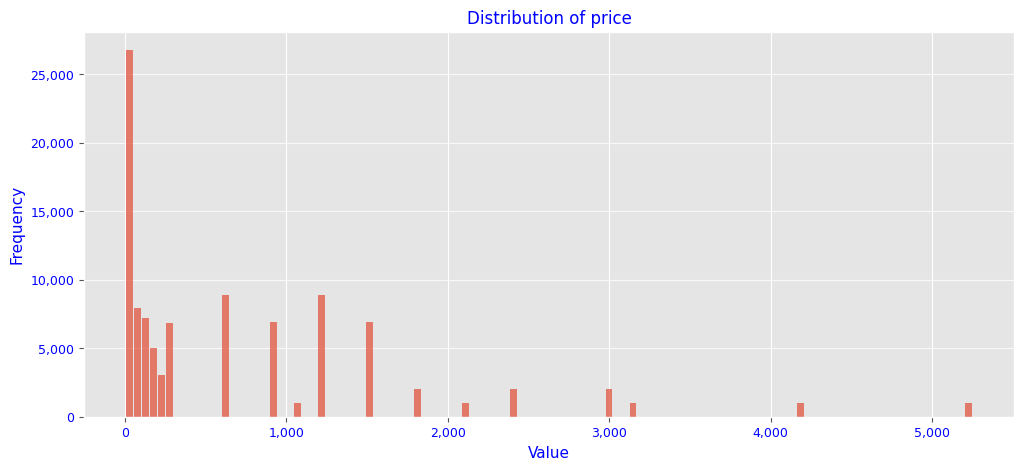

In [12]:
# Check missing values
explore.check_skewness('price')

In [15]:
# get statistical summary of categorical variables
explore.get_statistical_summary(variableType=None)

,variable,dtype,missing,%_missing,count,first,last,mean,std,min,25%,50%,75%,max,num_unique,median,mode,skewness,num_outliers,normality
0,invoice_no,Text,0,0.00,99457,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99457,NaN,I100008,NaN,None,NaN
1,customer_id,Text,0,0.00,99457,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99457,NaN,C100004,NaN,None,NaN
2,gender,Text,0,0.00,99457,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,Female,NaN,None,NaN
3,age,Integer,0,0.00,99457.00,NaT,NaT,43.43,14.99,18.00,30.00,43.00,56.00,69.00,52,43.00,37,0.01,0,False
4,category,Text,0,0.00,99457,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,Clothing,NaN,None,NaN
5,quantity,Integer,0,0.00,99457.00,NaT,NaT,3.00,1.41,1.00,2.00,3.00,4.00,5.00,5,3.00,3,-0.00,0,False
6,price,Float,0,0.00,99457.00,NaT,NaT,689.26,941.18,5.23,45.45,203.30,1200.32,5250.00,40,203.30,600.16,2.25,2002,False
7,payment_method,Text,0,0.00,99457,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,Cash,NaN,None,NaN
8,invoice_date,Date/Time,0,0.00,99457,2021-01-01,2023-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,797,2022-02-05 00:00:00,2021-11-24 00:00:00,NaN,None,NaN
9,shopping_mall,Text,0,0.00,99457,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,Mall of Istanbul,NaN,None,NaN


In [14]:
# get statistical summary of numerical variables
explore.get_statistical_summary(variableType='numerical')

,variable,dtype,missing,%_missing,count,mean,std,min,25%,50%,75%,max,num_unique,median,mode,skewness,num_outliers,normality
3,age,Integer,0,0.00,99457.00,43.43,14.99,18.00,30.00,43.00,56.00,69.00,52,43.00,37,0.01,0,False
5,quantity,Integer,0,0.00,99457.00,3.00,1.41,1.00,2.00,3.00,4.00,5.00,5,3.00,3,-0.00,0,False
6,price,Float,0,0.00,99457.00,689.26,941.18,5.23,45.45,203.30,1200.32,5250.00,40,203.30,600.16,2.25,2002,False
10,invoice_year,Integer,0,0.00,99457.00,2021.63,0.64,2021.00,2021.00,2022.00,2022.00,2023.00,3,2022.00,2022,0.51,0,False
12,total_revenue,Float,0,0.00,99457.00,2528.79,4222.48,5.23,136.35,600.17,2700.72,26250.00,40,600.17,1200.32,2.87,2002,False


## Sales Analysis

### 1. What was the total sales revenue for the last quarter?

In [11]:
# get data for last 3 months
last_date = df['invoice_date'].max()
three_months_ago = last_date - timedelta(days=90)
last_quarter_data = df[(df['invoice_date'] >= three_months_ago) & (df['invoice_date'] <= last_date)]

total_sales_revenue_last_quarter = round(last_quarter_data['total_revenue'].sum(),2)
total_sales_revenue_last_quarter = format(total_sales_revenue_last_quarter,',.2f')

print("Total sales revenue for the last quarter: ${}".format(total_sales_revenue_last_quarter))

Total sales revenue for the last quarter: $1,860,816.31


### 2. How does the sales revenue of this year compare to the same period last year?

In [12]:

def compare_sales_revenue(target_period):
    
    if not isinstance(target_period, int):
        print("Target period not valid")
        
    elif (target_period < 1) | (target_period > 12):
        print("Target period not valid")
 
    else:
        
        data = df.copy()

        # Convert 'invoice_month' to datetime format to extract the month number
        data['invoice_month'] = pd.to_datetime(data['invoice_month'], format='%B').dt.month

        this_year = datetime.now().year
        this_year_data = data[(data['invoice_year'] == this_year) & (data['invoice_month'] <= target_period)]

        # Filter data for the same period last year
        last_year = this_year - 1
        last_year_data = data[(data['invoice_year'] == last_year) & (data['invoice_month'] <= target_period)]

        # Calculate total sales revenue for this year and last year
        total_sales_revenue_this_year = this_year_data['total_revenue'].sum()
        total_sales_revenue_last_year = last_year_data['total_revenue'].sum()

        # Calculate the sales revenue difference and percentage change
        revenue_difference = total_sales_revenue_this_year - total_sales_revenue_last_year
        percentage_change = (revenue_difference / total_sales_revenue_last_year) * 100

        print(f"Sales revenue this year: ${format(total_sales_revenue_this_year,',.2f')}")
        print(f"Sales revenue last year: ${format(total_sales_revenue_last_year,',.2f')}")

        print(f"Revenue difference: ${format(revenue_difference,',.2f')}")
        print(f"Percentage change: {percentage_change:.2f}%")


In [13]:
compare_sales_revenue(8)

Sales revenue this year: $18,916,120.23
Sales revenue last year: $76,691,263.74
Revenue difference: $-57,775,143.51
Percentage change: -75.33%


### 3. What is the average transaction value for card purchases versus cash purchases?

In [14]:
# average transaction value for debit and credit card purchases
average_card_transaction = df[(df['payment_method'] == 'Credit Card') |\
                        (df['payment_method'] == 'Debit Card')]['total_revenue'].mean()

# average transaction value for cash purchases
average_cash_transaction = df[df['payment_method'] == 'Cash']['price'].mean()

print(f"Average card transaction value: ${average_card_transaction:,.2f}")
print(f"Average cash transaction value: ${average_cash_transaction:,.2f}")


Average card transaction value: $2,520.88
Average cash transaction value: $690.82


### 4. Which month had the highest sales revenue in the last year?

In [15]:
# sales revenue for last year
this_year = datetime.now().year
last_year = this_year - 1
last_year_data = df[df['invoice_year'] == last_year]
monthly_sales_last_year = last_year_data.groupby('invoice_month')['total_revenue'].sum()

# month with highest sales revenue
month_with_highest_sales = monthly_sales_last_year.idxmax()
sales_for_the_month = monthly_sales_last_year.max()

print(f"The month in the last year with the highest total sales: {month_with_highest_sales} - ${sales_for_the_month:,.2f}")

The month in the last year with the highest total sales: October - $10,072,915.55


### 5. How has the sales revenue changed over the past six months?

In [16]:
# get date for last 3 months
last_date = df['invoice_date'].max()
six_months_ago = last_date - timedelta(days=180)

# data for the last quarter
last_half_data = df[(df['invoice_date'] >= six_months_ago) & (df['invoice_date'] <= last_date)]

monthly_sales = last_half_data.groupby(last_half_data['invoice_date'].dt.to_period('M'))['total_revenue'].sum()
monthly_sales

invoice_date
2023-07   916750.45
2023-08   913654.79
2023-09   731473.04
2023-10   816291.56
2023-11   485230.74
2023-12   559294.01
Freq: M, Name: total_revenue, dtype: float64

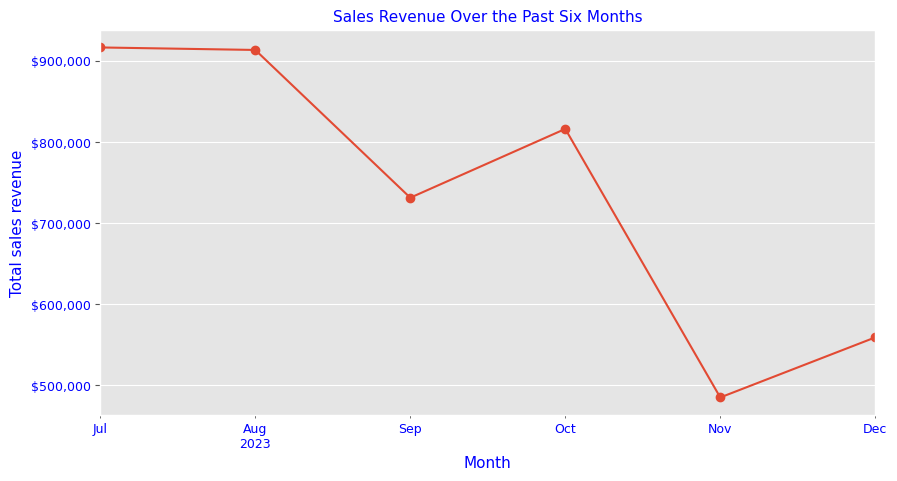

In [17]:
# Plot the sales revenue changes over the past six months
plt.figure(figsize=(10, 5))
monthly_sales.plot(kind='line', marker='o')

plt.title("Sales Revenue Over the Past Six Months", color='blue', fontsize=11)
plt.xlabel("Month",color='blue', fontsize=11)
plt.ylabel("Total sales revenue",color='blue', fontsize=11)

# add thousand separator to y-axis labels
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tick_params(axis='x', which='both', labelsize=9, labelcolor='blue')
plt.tick_params(axis='y', which='both', labelsize=9, labelcolor='blue')
plt.show()

**Observation**:

- There has been a decline in ales for the past six months.

### 6. Is there a specific day of the week that consistently generates the highest sales revenue?

The day of the week with the highest average sales: Monday


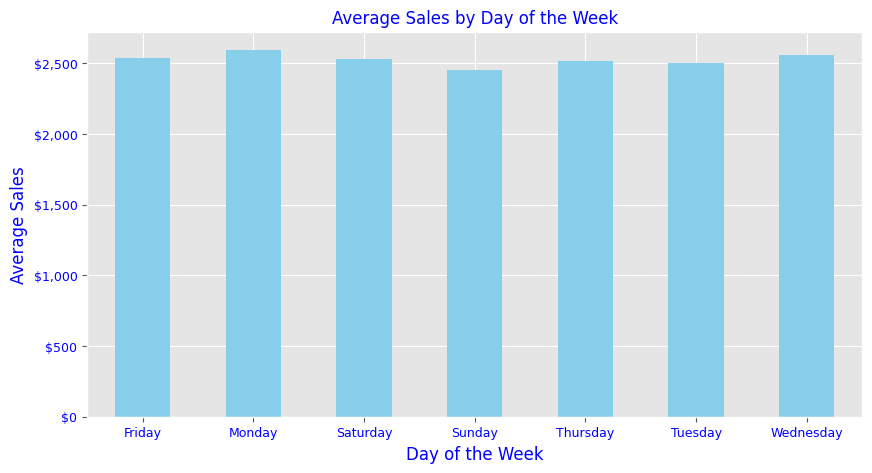

In [18]:
# average sales revenue for each day of week
df['day_of_week'] = df['invoice_date'].dt.day_name()
daily_avg_sales = df.groupby('day_of_week')['total_revenue'].mean()

# day of week with the highest average sales revenue
day_with_highest_avg_sales = daily_avg_sales.idxmax()
print("===========================================================")
print(f"The day of the week with the highest average sales: {day_with_highest_avg_sales}")

# Plot the average sales for each day of the week
plt.figure(figsize=(10, 5))
daily_avg_sales.plot(kind='bar', color='skyblue')
plt.title("Average Sales by Day of the Week", color='blue',fontsize=12)
plt.xlabel("Day of the Week",color='blue',fontsize=12)
plt.ylabel("Average Sales",color='blue',fontsize=12)

# add thousand separator to y-axis labels
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

plt.xticks(rotation=0)
plt.tick_params(axis='x', which='both', labelsize=9, labelcolor='blue')
plt.tick_params(axis='y', which='both', labelsize=9, labelcolor='blue')
plt.show()

### 7. What is the total revenue generated by each payment method?

In [19]:
# revenue for each payment method
revenue_by_payment_method = df.groupby('payment_method')['total_revenue'].sum().reset_index()
revenue_by_payment_method['total_revenue'] = \
            revenue_by_payment_method['total_revenue'].apply(format_revenue_with_thousand_separator)

revenue_by_payment_method.rename(columns={'payment_method':'Payment Method',
            'total_revenue':'Total Revenue'},inplace=True)

revenue_by_payment_method

,Payment Method,Total Revenue
0,Cash,"$112,832,243.02"
1,Credit Card,"$88,077,123.77"
2,Debit Card,"$50,596,427.46"


### 8. What is the correlation between invoice quantity and price?

In [20]:
# correlation between invoice quantity and price
correlation = df['quantity'].corr(df['price'])

print(f"Correlation between invoice quantity and price: {correlation:.3f}")

Correlation between invoice quantity and price: 0.345


### 9. How does sales revenue vary among different shopping malls?

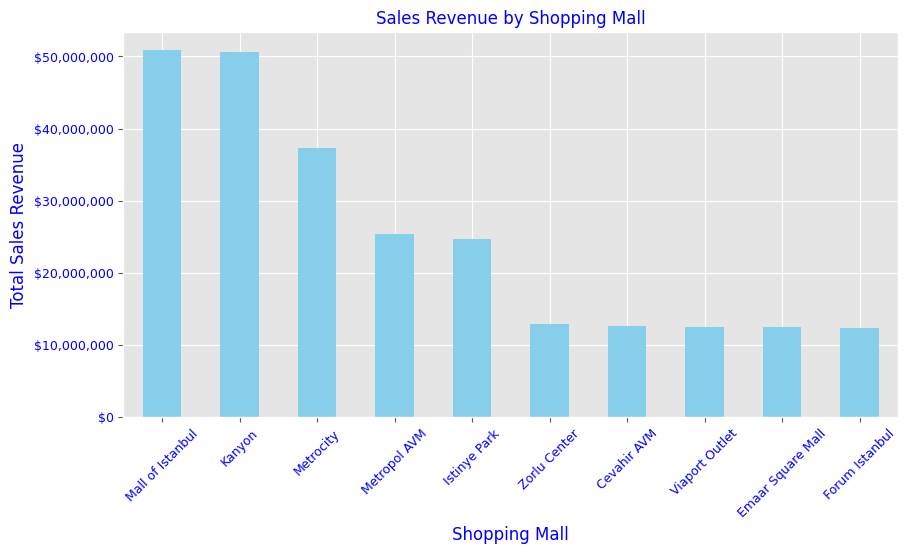

In [21]:
# total sales revenue for each mall
revenue_by_mall = df.groupby('shopping_mall')['total_revenue'].sum()
revenue_by_mall = revenue_by_mall.sort_values(ascending=False)

# Plot the sales revenue for each shopping mall
plt.figure(figsize=(10, 5))
revenue_by_mall.plot(kind='bar', color='skyblue')
plt.title("Sales Revenue by Shopping Mall", color='blue',fontsize=12)
plt.xlabel("Shopping Mall",color='blue',fontsize=12)
plt.ylabel("Total Sales Revenue",color='blue',fontsize=12)

# add thousand separator to y-axis labels
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

plt.xticks(rotation=45)
plt.tick_params(axis='x', which='both', labelsize=9, labelcolor='blue')
plt.tick_params(axis='y', which='both', labelsize=9, labelcolor='blue')
plt.show()

### 10. Can you identify any trends or patterns in the distribution of sales revenue?

#### a. Sales trend by month

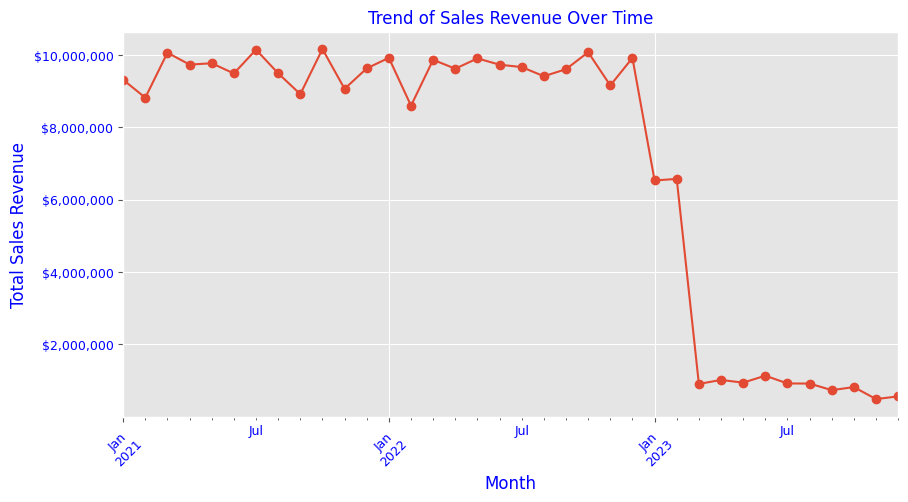

In [22]:
# total sales revenue for each month
monthly_revenue = df.groupby(df['invoice_date'].dt.to_period('M'))['total_revenue'].sum()

# Plot the trend of sales revenue over time
plt.figure(figsize=(10, 5))
monthly_revenue.plot(kind='line', marker='o')
plt.title("Trend of Sales Revenue Over Time", color='blue', fontsize=12)
plt.xlabel("Month",color='blue', fontsize=12)
plt.ylabel("Total Sales Revenue",color='blue', fontsize=12)

# add thousand separator to y-axis labels
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

plt.xticks(rotation=45)
plt.tick_params(axis='x', which='both', labelsize=9, labelcolor='blue')
plt.tick_params(axis='y', which='both', labelsize=9, labelcolor='blue')
plt.show()

#### b. Sales trend by category

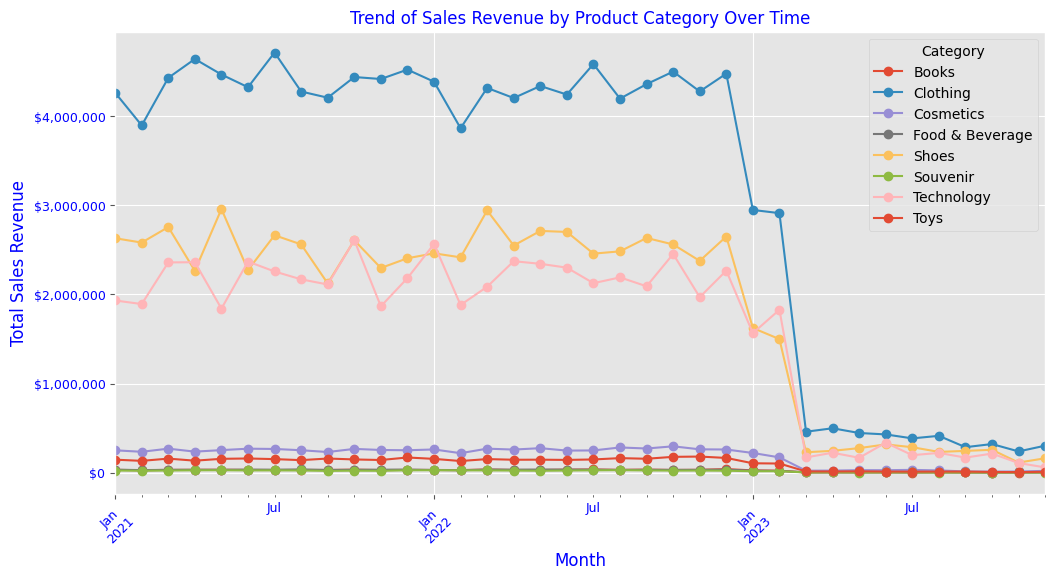

In [23]:
# total sales revenue for each category
category_monthly_revenue = df.groupby([df['invoice_date'].dt.to_period('M'),
                'category'])['total_revenue'].sum().reset_index()

# Pivot the data to create a matrix with months as rows, categories as columns, and sales revenue as values
pivot_table = category_monthly_revenue.pivot(index='invoice_date', columns='category',
                values='total_revenue')

# Plot the trend of sales revenue for each product category over time
pivot_table.plot(kind='line', marker='o', figsize=(12,6))
plt.title("Trend of Sales Revenue by Product Category Over Time",color='blue', fontsize=12)
plt.xlabel("Month",color='blue', fontsize=12)
plt.ylabel("Total Sales Revenue",color='blue', fontsize=12)

# add thousand separator to y-axis labels
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

plt.xticks(rotation=45)
plt.legend(title='Category')
plt.tick_params(axis='x', which='both', labelsize=9, labelcolor='blue')
plt.tick_params(axis='y', which='both', labelsize=9, labelcolor='blue')
plt.show()

#### c. Seasonality of sales revenue

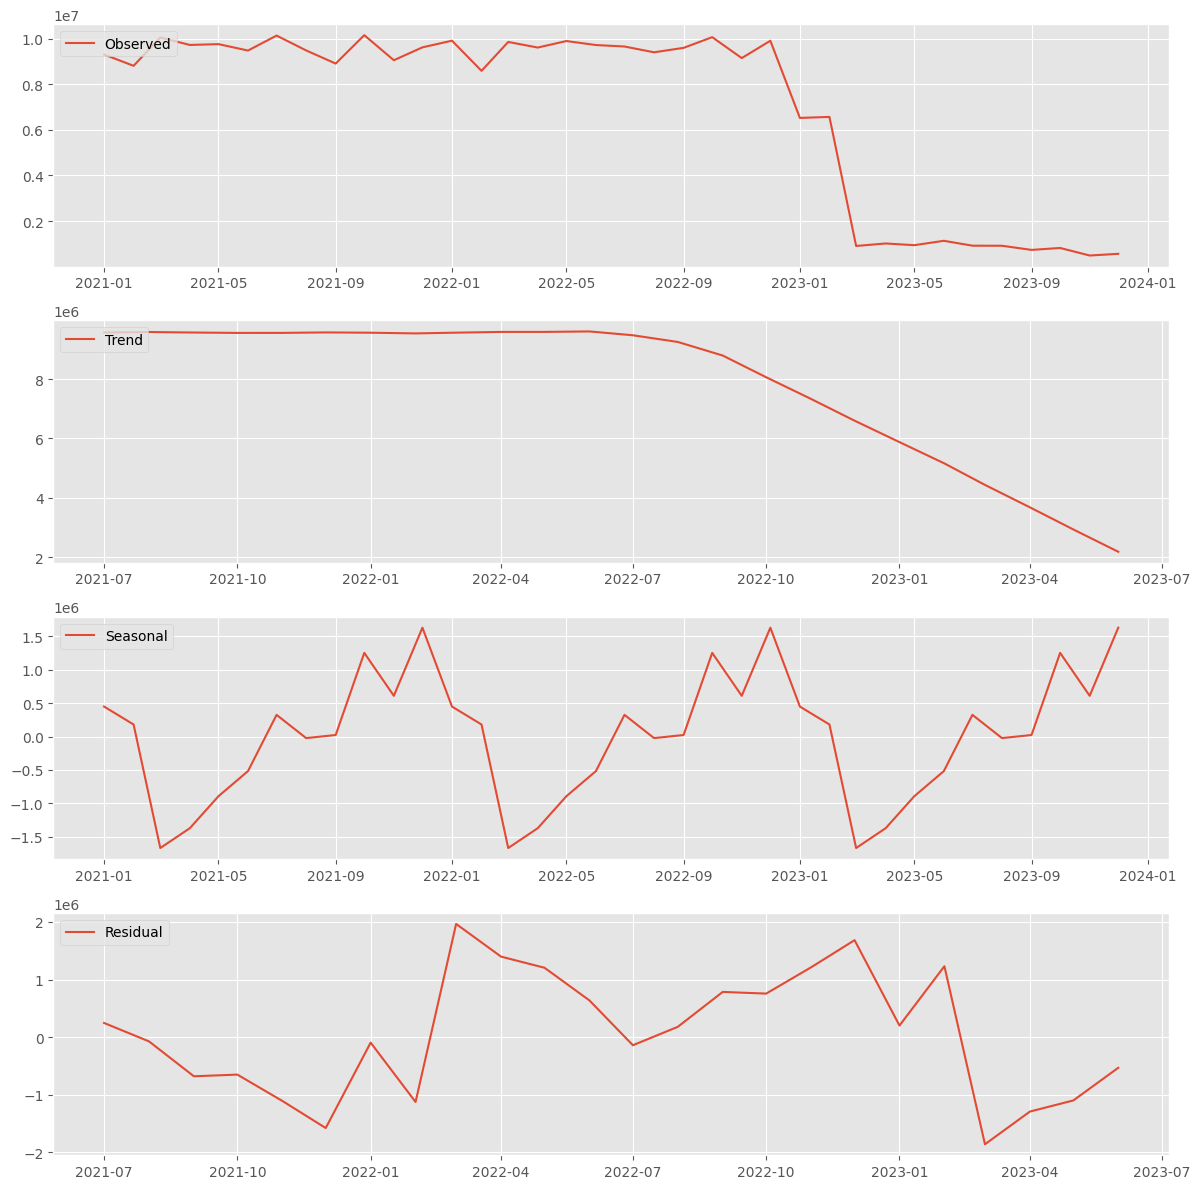

In [24]:
# total sales revenue for each month
monthly_revenue = df.groupby(df['invoice_date'].dt.to_period('M'))['total_revenue'].sum()

# Convert PeriodIndex to regular DatetimeIndex
monthly_revenue.index = monthly_revenue.index.to_timestamp()

# Perform time series decomposition (seasonal, trend, and residual)
decomposition = sm.tsa.seasonal_decompose(monthly_revenue, model='additive')

# Plot the decomposed time series components
plt.figure(figsize=(12, 12))
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#### d. Sales trend by payment method

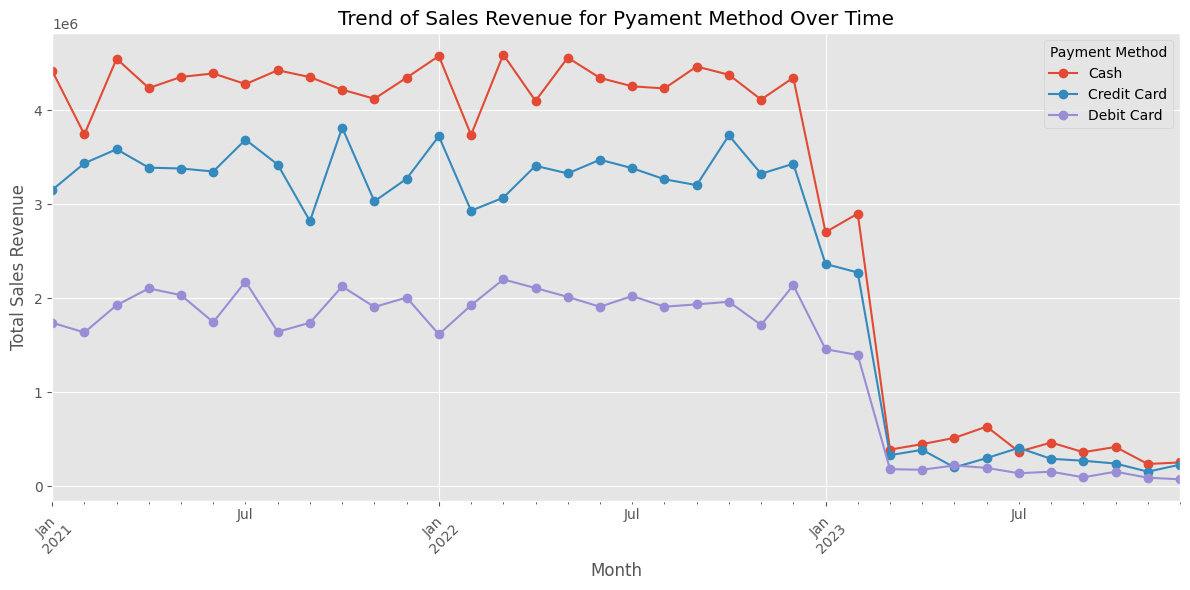

In [25]:
# Group data by product and month, and calculate total sales revenue for each combination
product_monthly_revenue = df.groupby([df['invoice_date'].dt.to_period('M'), 'payment_method'])['total_revenue'].sum().reset_index()

# Pivot the data to create a matrix with months as rows, products as columns, and sales revenue as values
pivot_table = product_monthly_revenue.pivot(index='invoice_date', columns='payment_method', values='total_revenue')

# Plot the trend of sales revenue for each product over time
pivot_table.plot(kind='line', marker='o',figsize=(12, 6))
plt.title("Trend of Sales Revenue for Pyament Method Over Time")
plt.xlabel("Month")
plt.ylabel("Total Sales Revenue")
plt.xticks(rotation=45)
plt.legend(title='Payment Method')
plt.grid(True)
plt.tight_layout()
plt.show()

#### e. Product launch trends

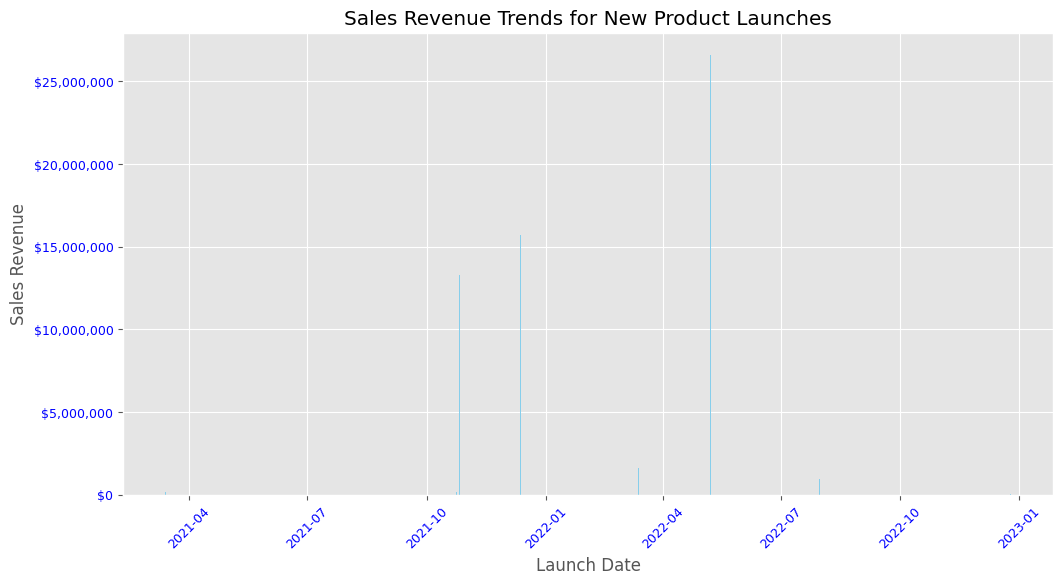

,category,Launch Date,Sales Revenue
0,Clothing,2022-05-08,"$26,603,292.32"
1,Shoes,2021-12-12,"$15,679,441.25"
2,Books,2021-10-24,"$189,844.65"
3,Cosmetics,2022-03-13,"$1,590,090.62"
4,Food & Beverage,2022-12-25,"$62,440.97"
5,Toys,2022-07-31,"$952,913.92"
6,Technology,2021-10-26,"$13,264,650.00"
7,Souvenir,2021-03-14,"$150,179.19"


In [26]:
# launch date of each new product
new_product_launches = df[df['category'].duplicated(keep='first') == False]

# sales revenue for each new product in the months following its launch
months_after_launch = 6  
new_product_performance = []

for index, row in new_product_launches.iterrows():
    launch_date = row['invoice_date']
    product_name = row['category']
    end_date = launch_date + pd.DateOffset(months=months_after_launch)
    product_sales = df[(df['category'] == product_name) & (df['invoice_date'] >= launch_date) & (df['invoice_date'] <= end_date)]['total_revenue'].sum()
    new_product_performance.append({'category': product_name, 'Launch Date': launch_date, 'Sales Revenue': product_sales})

# new product performance
new_product_performance_df = pd.DataFrame(new_product_performance)

# Plot the sales revenue trends for new products
plt.figure(figsize=(12, 6))
plt.bar(new_product_performance_df['Launch Date'], new_product_performance_df['Sales Revenue'], color='skyblue')
plt.title("Sales Revenue Trends for New Product Launches")
plt.xlabel("Launch Date")
plt.ylabel("Sales Revenue")

# add thousand separator to y-axis labels
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

plt.xticks(rotation=45)
plt.tick_params(axis='x', which='both', labelsize=9, labelcolor='blue')
plt.tick_params(axis='y', which='both', labelsize=9, labelcolor='blue')
plt.show()

new_product_performance_df['Sales Revenue'] = new_product_performance_df['Sales Revenue'].apply(format_revenue_with_thousand_separator)
new_product_performance_df